In [1]:
!pip install transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import evaluate
import json
import numpy as np
from sklearn.model_selection import train_test_split


In [4]:
base_dir = "/content/drive/MyDrive/Colab Notebooks"
train_path = f"{base_dir}/emotion_train.jsonl"
valid_path = f"{base_dir}/emotion_val.jsonl"
label_map_path = f"{base_dir}/label2id.json"

In [5]:
with open(label_map_path, "r", encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v: k for k, v in label2id.items()}
num_labels = len(label2id)

In [6]:
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line.strip()) for line in f]

train_data = load_jsonl(train_path)
valid_data = load_jsonl(valid_path)

In [7]:
all_data = train_data + valid_data

labels = [item['label_id'] for item in all_data]

train_split, val_split = train_test_split(
    all_data,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=labels
)

In [8]:
model_name = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/514 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_list(train_split).map(preprocess, batched=False)
valid_dataset = Dataset.from_list(val_split).map(preprocess, batched=False)

Map:   0%|          | 0/42705 [00:00<?, ? examples/s]

Map:   0%|          | 0/10677 [00:00<?, ? examples/s]

In [10]:
train_dataset = train_dataset.rename_column("label_id", "label")
valid_dataset = valid_dataset.rename_column("label_id", "label")

In [11]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_metric.compute(predictions=preds, references=labels)
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }

In [12]:
from transformers import TrainingArguments
from transformers import Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/emotion_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    logging_dir="./logs",                # 로그 저장
    logging_steps=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="f1",         # 또는 "accuracy"
    save_total_limit=2,
    report_to="none"
)


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-13-1919112066.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.875200,0.687542,0.722113,0.721494
2,0.609000,0.667143,0.742812,0.743457
3,0.487200,0.703916,0.739159,0.735924
4,0.375900,0.784993,0.738878,0.740552
5,0.282500,0.916681,0.737848,0.738745
6,0.215400,1.175382,0.731011,0.732356
7,0.168400,1.336748,0.733352,0.735154
8,0.128400,1.592984,0.728669,0.730686
9,0.103600,1.670364,0.732696,0.733060
10,0.077500,1.755104,0.731947,0.732885


TrainOutput(global_step=26700, training_loss=0.33229337485095534, metrics={'train_runtime': 2712.3409, 'train_samples_per_second': 157.447, 'train_steps_per_second': 9.844, 'total_flos': 2.80914028971264e+16, 'train_loss': 0.33229337485095534, 'epoch': 10.0})

In [15]:
# trainer.train(resume_from_checkpoint = True)

In [16]:
trainer.state.best_model_checkpoint

'/content/drive/MyDrive/emotion_model/checkpoint-5340'

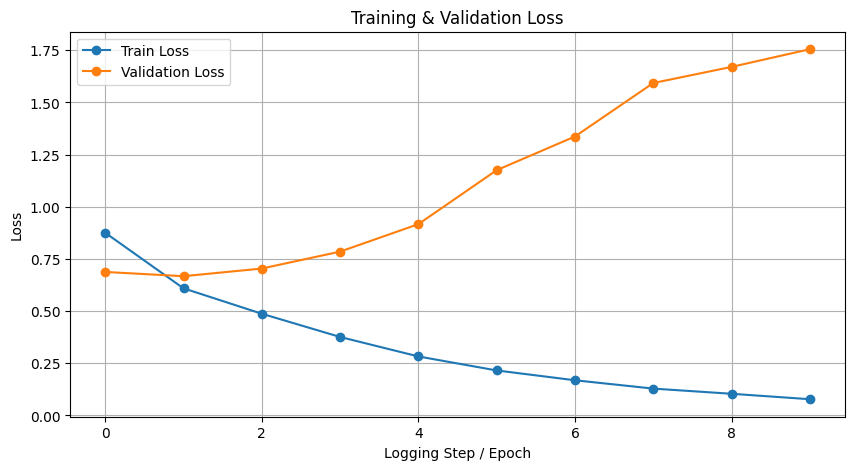

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 🪄 학습 로그에서 loss 값 확인
training_logs = trainer.state.log_history

# 📝 로그에서 loss 값만 추출
train_loss = [log["loss"] for log in training_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in training_logs if "eval_loss" in log]

# 🖼️ 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss", marker='o')
plt.plot(eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Logging Step / Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [38]:
from sklearn.metrics import classification_report

with open(label_map_path, "r", encoding="utf-8") as f:
    label2id = json.load(f)
id2label = {v: k for k, v in label2id.items()}

label_names = [id2label[i] for i in range(len(id2label))]

predictions = trainer.predict(valid_dataset)
preds = predictions.predictions.argmax(axis=-1)
labels = predictions.label_ids
print("Classification Report on Validation Set:")
print(classification_report(labels, preds, target_names=label_names))

Classification Report on Validation Set:
              precision    recall  f1-score   support

          기쁨       0.89      0.95      0.92       243
          분노       0.75      0.70      0.72      3216
          불안       0.76      0.86      0.80      2087
          슬픔       0.84      0.80      0.82      3079
          중립       0.69      0.59      0.64       966
          혐오       0.49      0.59      0.54      1086

    accuracy                           0.74     10677
   macro avg       0.74      0.75      0.74     10677
weighted avg       0.75      0.74      0.74     10677



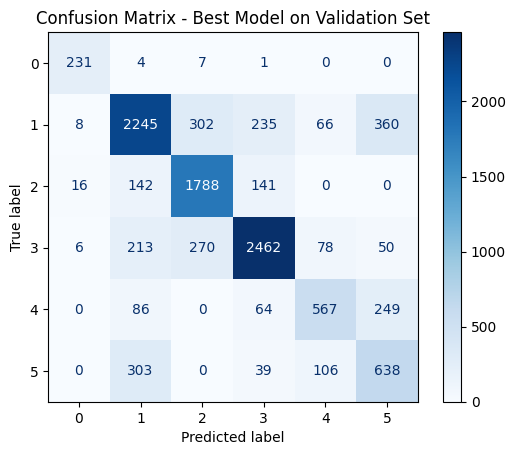

In [41]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


# 1. 베스트 모델 경로
best_checkpoint = trainer.state.best_model_checkpoint

# 2. 베스트 모델 불러오기
best_model = AutoModelForSequenceClassification.from_pretrained(best_checkpoint)

# 3. 베스트 모델로 예측 수행
# trainer의 predict 메서드로 eval_dataset에 대해 예측 가능
predictions_output = trainer.predict(valid_dataset)

# logits → 예측 라벨 변환 (argmax)
preds = np.argmax(predictions_output.predictions, axis=1)

# 실제 라벨
labels = predictions_output.label_ids

# 4. 혼동 행렬 계산 및 시각화
cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Best Model on Validation Set")
plt.show()
